In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, make_scorer
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from joblib import dump

In [52]:
class Models():
    algorithms = [
        ("knn", KNeighborsClassifier()),
        #("dt", DecisionTreeClassifier()),
        #("svm", SVC()),
        ("rf", RandomForestClassifier()),
        #("ada", AdaBoostClassifier()) 
    ]
    
    def train_all(self, data, response):
        for name, algorithm in self.algorithms:
            algorithm.fit(X=data, y=response)

    def save(self, sufix):
        for name, algorithm in self.algorithms:
            dump(algorithm, f"models/{name}_model_{sufix}.joblib")

    def predict(self, X_val):
        predictions = []

        for name, model in self.algorithms:
            predictions.append((name, model.predict(X_val)))
        
        return predictions
    
    def predict_proba(self, X_val):
        predictions = []

        for name, model in self.algorithms:
            predictions.append((name, model.predict_proba(X_val)[::,1]))
        
        return predictions
    
    def cross_validate_model(self, name, model, X, y, cv, scoring):
        res = cross_validate(model, X, y, cv=cv, scoring=scoring)
        return [name, res["test_accuracy"].mean(), res["test_precision"].mean(), res["test_recall"].mean(), res["test_f1"].mean(), res["test_mcc"].mean()]
    
    def cross_validate(self, X, y, cv, scoring):
        score_list = []
        for name, model in self.algorithms:
            score_list.append(self.cross_validate_model(name, model, X, y, cv, scoring))
        
        return pd.DataFrame(score_list, columns=["algorithm", "accuracy", "precision", "recall", "f1", "mcc"])

    def cv_predict(self, X, y, cv):
        self.predictions = cross_val_predict(self.model_instance, X, y, cv=cv)
        return self.get_metrics(y)

    def get_metrics(self, X_val,y_true):
        export_list = []
        predictions = self.predict(X_val)
        for name, y_pred in predictions:
            acc_value = accuracy_score(y_pred=y_pred, y_true=y_true) 
            recall_value = recall_score(y_pred=y_pred, y_true=y_true)
            precision_value = precision_score(y_pred=y_pred, y_true=y_true) 
            f1_value = f1_score(y_pred=y_pred, y_true=y_true)
            mcc_value = matthews_corrcoef(y_pred=y_pred, y_true=y_true)
            cm = confusion_matrix(y_pred=y_pred, y_true=y_true)
            export_list.append((name, acc_value, recall_value, precision_value, f1_value, mcc_value, cm))

        return pd.DataFrame(export_list, columns=["algorithm", "acc", "recall", "precision", "f1", "mcc", "cm"])

# Data load

In [4]:
df = pd.read_csv('../data/encoded/fft_ANDN920101.csv')
df.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_4087,p_4088,p_4089,p_4090,p_4091,p_4092,p_4093,p_4094,p_4095,response
0,1736.78,1730.097781,1710.143817,1677.194657,1631.706140,1574.305873,1505.782897,1427.074715,1339.251925,1243.500729,...,7.564455,6.925004,6.218049,5.451810,4.635127,3.777726,2.891176,1.992699,1.127448,1
1,1455.06,1451.041913,1439.027637,1419.136656,1391.566536,1356.590586,1314.554635,1265.872941,1211.023318,1150.541520,...,5.104631,5.401888,5.662994,5.887883,6.076814,6.230261,6.348791,6.432970,6.483270,1
2,890.09,889.150867,886.337020,881.659100,875.134789,866.788729,856.652413,844.764042,831.168355,815.916427,...,6.708745,6.921748,7.113987,7.283848,7.429936,7.551071,7.646289,7.714838,7.756183,1
3,4379.90,4272.687253,3960.494775,3470.669678,2845.603020,2138.331341,1407.099109,709.518428,98.053637,391.939628,...,16.456478,14.916973,12.478986,9.576113,7.123597,6.642044,8.329246,10.555320,12.204887,1
4,1135.64,1133.749021,1128.087383,1118.688910,1105.609707,1088.927759,1068.742383,1045.173519,1018.360882,988.462972,...,5.033257,4.790180,4.525216,4.247869,3.969779,3.705017,3.470107,3.283237,3.162075,1


# Data split

In [14]:
X = df.drop('response', axis=1)
y = df['response']

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

# Model training

In [53]:
models_instance = Models()
models_instance.train_all(X_train, y_train)

# Model evaluation

In [54]:
metrics_val = models_instance.get_metrics(X_val, y_val)
metrics_test = models_instance.get_metrics(X_test, y_test)
metrics = pd.merge(metrics_val, metrics_test, on="algorithm", suffixes=("_val", "_test"))
metrics

,algorithm,acc_val,recall_val,precision_val,f1_val,mcc_val,cm_val,acc_test,recall_test,precision_test,f1_test,mcc_test,cm_test
0,knn,0.796139,0.516517,0.625455,0.565789,0.437564,"[[859, 103], [161, 172]]",0.790132,0.550649,0.621701,0.584022,0.445839,"[[925, 129], [173, 212]]"
1,rf,0.845560,0.591592,0.754789,0.663300,0.572059,"[[898, 64], [136, 197]]",0.836692,0.576623,0.755102,0.653903,0.558091,"[[982, 72], [163, 222]]"


## ROC y AUC

In [55]:
predictions = models_instance.predict_proba(X_test)
predictions

[('knn', array([0. , 0.2, 0. , ..., 0. , 1. , 0. ])),
 ('rf',
  array([0.012869  , 0.52116711, 0.        , ..., 0.16302531, 0.87737177,
         0.02652884]))]

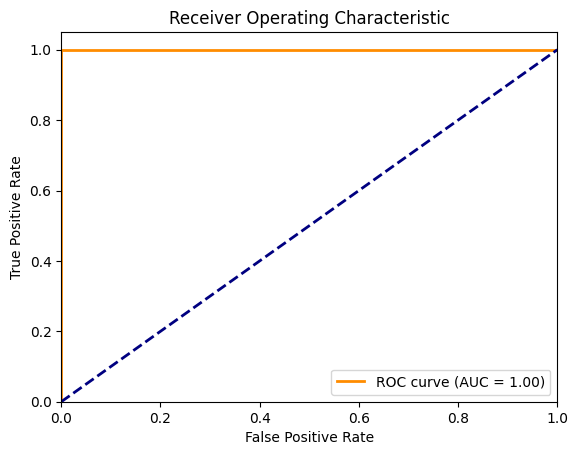

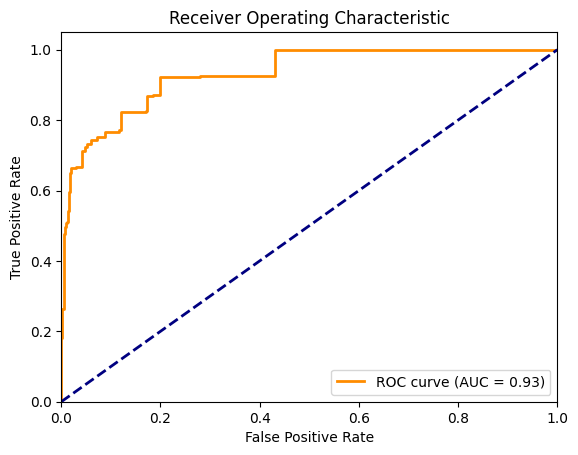

In [56]:
for name, y_pred in predictions:
    
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


## Plot

In [10]:
import matplotlib as plt

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Cross Validation

In [ ]:
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score),
    "recall": make_scorer(recall_score),
    "f1": make_scorer(f1_score),
    "mcc": make_scorer(matthews_corrcoef)
}
cv_metrics = models_instance.cross_validate(X_train, y_train, cv=5, scoring=scoring)
cv_metrics